### Importing libraries

In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from Functions import video_generation, extracting_files, neural_networks, anoamly_detection

In [2]:
video_gen = video_generation.VideoGeneration()
extract_files = extracting_files.ExtractingFiles()
neural_network = neural_networks.NeuralNetwork()
anomaly_detection = anoamly_detection.AnomalyDetection()

In [3]:
zipped_file = os.getenv("ziped_file")
sesnor_data = os.getenv("folder_name")
output_dir = os.getenv('sensor_heatmaps')
video_output = os.getenv('temperature_output')
placement_json = os.getenv('placement_json')
column_name = os.getenv('column_name')

In [4]:
extract_files.extract_zip(zipped_file, sesnor_data)

'Files extracted to Sensor_data'

In [5]:
initial_data = extract_files.read_all_excel_files(sesnor_data)

Reading file: Sensor_data\Data17052024-210552024\Sensor data[0474D,04750,04754,04756,04757,0475A,0475C,0475D,04762,04763,04765,04768,0476E,04771,04773,0477F,04787,04789,0478A,0478C](01_01_2024-20_05_2024) (1).xlsx
Reading file: Sensor_data\Data17052024-210552024\Sensor data[0478E,04791,04792,04796,0479B,0479D,0479E,047A8,047AA,047AD,047B2,047B6,047B7,047B8,047BA,047BB,047BC,047C1](01_01_2024-20_05_2024).xlsx
Reading file: Sensor_data\Data17052024-210552024\Sensor data[047C2,047C4,047C5,047C7,047C8,047C9,047CA,047CB,047CD,047CE,047D2,047D3,047D4,047D6,047D7,047DD,047F7,04802,04804,0480E](01_01_2024-20_05_2024).xlsx


In [6]:
initial_data['Day'] = pd.DatetimeIndex(initial_data['Time']).day
initial_data['Time_Instance'] = pd.DatetimeIndex(initial_data['Time']).time
initial_data['Year'] = pd.DatetimeIndex(initial_data['Time']).year
initial_data['Month'] = pd.DatetimeIndex(initial_data['Time']).month

In [7]:
initial_data.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Day,Time_Instance,Year,Month
0,2024-04-16 13:09:53,21.95,50.3,0474D,0474D T/RH IP67,16,13:09:53,2024,4
1,2024-04-16 13:14:52,22.5,34.7,0474D,0474D T/RH IP67,16,13:14:52,2024,4
2,2024-04-16 13:19:54,24.05,34.7,0474D,0474D T/RH IP67,16,13:19:54,2024,4
3,2024-04-16 13:24:53,24.25,34.7,0474D,0474D T/RH IP67,16,13:24:53,2024,4
4,2024-04-16 13:29:52,24.15,35.2,0474D,0474D T/RH IP67,16,13:29:52,2024,4


In [8]:
with open(placement_json, 'r') as file:
    data = json.load(file)

keys_list = list(data.keys())

In [9]:
df_sorted = extract_files.sorting_data(initial_data, keys_list)

combined_data = df_sorted.copy()
combined_data = combined_data.drop_duplicates(subset=['Time', column_name])

In [10]:
combined_data.isnull().sum()

Time                0
Temperature      9351
Humidity         9351
Sensor ID           0
Sensor Name         0
Day                 0
Time_Instance       0
Year                0
Month               0
dtype: int64

In [11]:
sample_dataset = combined_data.copy()

sample_dataset = sample_dataset.groupby(column_name).apply(lambda x: x.tail(30)).reset_index(drop=True)

sample_dataset = extract_files.sorting_data(sample_dataset, keys_list)

C:\Users\malla\AppData\Local\Temp\ipykernel_18964\2418632121.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_dataset = sample_dataset.groupby(column_name).apply(lambda x: x.tail(30)).reset_index(drop=True)


In [12]:
frames = video_gen.frames_generation(sample_dataset, output_dir)

video_gen.video_generation(frames, video_output)

'Video saved as: sensor_heatmaps_temperature_video.avi'

In [13]:
combined_data['Humidity'] = combined_data['Humidity'].astype('float')
combined_data['Temperature'] = combined_data['Temperature'].astype('float')

In [14]:
list_sensors = ['04773','047B7','047B6','047AA','0478A']
timeseries_plot_data = combined_data[combined_data[column_name].isin(list_sensors)]

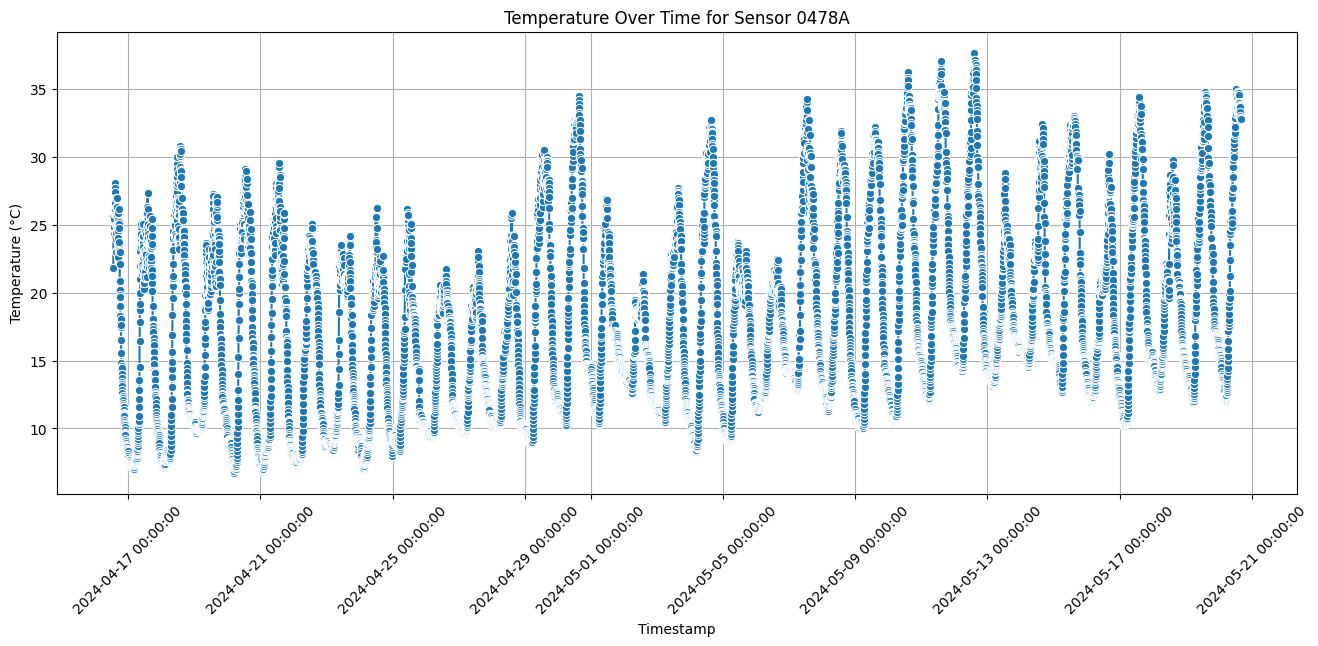

In [15]:
# Specify the sensor ID to plot
sensor_id = np.random.choice(timeseries_plot_data[column_name])

# Filter data for the specified sensor
sensor_data = timeseries_plot_data[timeseries_plot_data[column_name] == sensor_id]

# Create a figure for reuse
plt.figure(figsize=(16, 6))
sns.lineplot(x='Time', y='Temperature', data=sensor_data, marker='o')
plt.title(f'Temperature Over Time for Sensor {sensor_id}')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [16]:
combined_data['flag'] = combined_data.isna().any(axis=1).astype(int)

In [17]:
if combined_data['Temperature'].isnull().sum() > 0 or combined_data['Humidity'].isnull().sum() > 0:
    if combined_data['Temperature'].isnull().sum() > 0:
        combined_data = neural_network.train_and_fill(combined_data, 'Temperature', 100)
    if combined_data['Humidity'].isnull().sum() > 0:
        combined_data = neural_network.train_and_fill(combined_data, 'Humidity', 100)
else:
    print('No null values detected!!!!!!')

Epoch 1/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 8.0181 - val_loss: 7.1651
Epoch 2/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 5.2914 - val_loss: 5.2205
Epoch 3/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 5.1154 - val_loss: 4.9240
Epoch 4/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 4.9399 - val_loss: 5.2595
Epoch 5/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 4.9156 - val_loss: 4.8136
Epoch 6/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 4.7835 - val_loss: 4.8461
Epoch 7/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 4.7133 - val_loss: 4.8354
Epoch 8/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 4.7304 - val_loss: 4.7648
Epoch 9/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 4.6200 - val_loss: 5.0897
Epoch 10/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 4.5234 - val_loss: 4.7190
Epoch 11/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 4.4803 - val_loss: 5.1357
Epoch 12/20
8008/80

In [18]:
final_dataset = combined_data.copy()

final_dataset[final_dataset['flag'] == 1].head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Day,Time_Instance,Year,Month,flag
358,2024-05-05 05:01:20,8.69,79.56,047D6,047D6 T/RH IP67,5,05:01:20,2024,5,1
851,2024-05-20 08:31:34,14.08,79.48,047D6,047D6 T/RH IP67,20,08:31:34,2024,5,1
987,2024-05-07 09:29:43,21.98,56.40,047D6,047D6 T/RH IP67,7,09:29:43,2024,5,1
1001,2024-05-07 10:39:40,24.21,48.01,047D6,047D6 T/RH IP67,7,10:39:40,2024,5,1
1038,2024-05-20 15:01:20,29.77,41.13,047D6,047D6 T/RH IP67,20,15:01:20,2024,5,1


In [19]:
anomalies_list = []
temperature_color = 'green'
humidity_color = 'blue'

for sensor_id, sensor_data in combined_data.groupby(column_name):
    sensor_anomalies = anomaly_detection.detect_anomalies(sensor_data, sensor_id, temperature_color, humidity_color)
    anomalies_list.append(sensor_anomalies)

all_anomalies = pd.concat(anomalies_list)

In [20]:
non_anomalous_data = all_anomalies[(all_anomalies['Temperature_anomaly'] == 0) & (all_anomalies['Humidity_anomaly'] == 0)]

X_train = non_anomalous_data[['Temperature', 'Humidity']]
y_train_temp = non_anomalous_data['Temperature']
y_train_humidity = non_anomalous_data['Humidity']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [21]:
non_anomalous_data.shape

(560317, 12)

In [22]:
mlp_temp = anomaly_detection.training_anomaly_model(X_train_scaled, y_train_temp, y_train_humidity, 'temperature')

Epoch 1/20


e:\Final Desertation\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6129/6129 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 9.3875 - val_loss: 7.7217e-04
Epoch 2/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0066 - val_loss: 5.2127e-05
Epoch 3/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0024 - val_loss: 9.3387e-05
Epoch 4/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0027 - val_loss: 3.4362e-05
Epoch 5/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0024 - val_loss: 1.2026e-05
Epoch 6/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0017 - val_loss: 0.0055
Epoch 7/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0020 - val_loss: 0.0181
Epoch 8/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0016 - val_loss: 1.7430e-04
Epoch 9/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0019 - val_loss: 4.7880e-06
Epoch 10/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0016 - val_loss: 2.5595e-05
Epoch 11/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0012 - val_loss: 8.7811e-05
Epoch

In [23]:
mlp_humidity = anomaly_detection.training_anomaly_model(X_train_scaled, y_train_temp, y_train_humidity, 'humidity')

Epoch 1/20


e:\Final Desertation\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6129/6129 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 191.5373 - val_loss: 0.0185
Epoch 2/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0302 - val_loss: 0.0013
Epoch 3/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0229 - val_loss: 0.0033
Epoch 4/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0237 - val_loss: 0.0148
Epoch 5/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0172 - val_loss: 0.0023
Epoch 6/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0162 - val_loss: 0.0161
Epoch 7/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0145 - val_loss: 0.0200
Epoch 8/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0201 - val_loss: 0.0020
Epoch 9/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0218 - val_loss: 1.1262e-04
Epoch 10/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0118 - val_loss: 1.1906e-04
Epoch 11/20
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0174 - val_loss: 0.0016
Epoch 12/20
6129/6129 ━━━━━━━━━

In [24]:
anomalies = all_anomalies[(all_anomalies['Temperature_anomaly'] == 1) & (all_anomalies['Humidity_anomaly'] == 1)].copy()

X_anomalies = anomalies[['Temperature', 'Humidity']]
X_anomalies_scaled = scaler.transform(X_anomalies)

anomalies.loc[anomalies['Temperature_anomaly'] == 1, 'Temperature'] = 0
anomalies.loc[anomalies['Humidity_anomaly'] == 1, 'Humidity'] = 0

In [25]:
anomalies['Temperature'] = np.round(mlp_temp.predict(X_anomalies_scaled), 2)
anomalies['Humidity'] = np.round(mlp_humidity.predict(X_anomalies_scaled), 2)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [29]:
all_anomalies.update(anomalies[['Temperature', 'Humidity']])
final_processed_data = all_anomalies.copy()

# final_anomalies = final_processed_data[(final_processed_data['Temperature_anomaly'] == 1) & (final_processed_data['Humidity_anomaly'] == 1)]

In [30]:
lastday = final_processed_data['Time'].max().date()
last_day_records = final_processed_data[final_processed_data['Time'].dt.date == lastday]

# empty_data = final_processed_data[final_processed_data['flag'] == 1]
# sensor_empty_data = empty_data[empty_data['Time'].dt.date == lastday]

sensor_sample_data = df_sorted[df_sorted['Time'].dt.date == lastday]

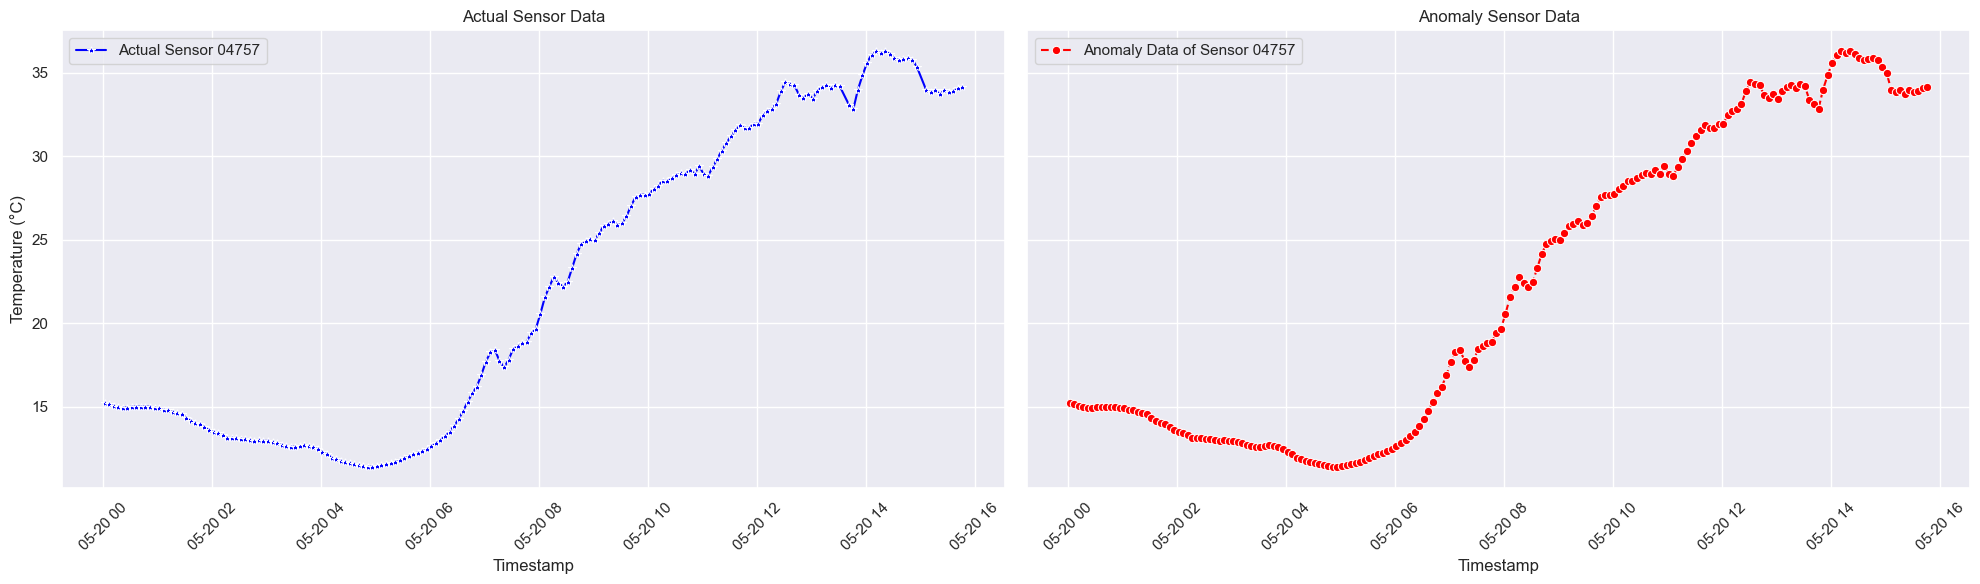

In [35]:
# Set style
sns.set(style="darkgrid")

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Original data
sensor_data = sensor_sample_data[sensor_sample_data[column_name] == '04757']
sns.lineplot(ax=axs[0], x='Time', y='Temperature', data=sensor_data, 
             marker='*', color='blue',
             label='Actual Sensor 04757')

# Filtered data
filtered_sensor_data = last_day_records[last_day_records[column_name] == '04757']
sns.lineplot(ax=axs[1], x='Time', y='Temperature', data=filtered_sensor_data, 
             marker='o', color='red',
             linestyle='--', label='Anomaly Data of Sensor 04757')

# Titles and labels
axs[0].set_title('Actual Sensor Data')
axs[1].set_title('Anomaly Sensor Data')

for ax in axs:
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Temperature (°C)')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('Compare/original_and_filtered_plots_side_by_side.png')
plt.show()